<h1> TENSORFLOW MACHINE LEARNING </h1>

In [65]:
# CORE ALGORITHMS

# importing modules
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [66]:
# showing the first 5 rows
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [67]:
# training the feature columns

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) # associate every feature name with a list of unique vocabulary

for feature_name in NUMERIC_COLUMNS: 
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32)) # for the ones with numerical features


# print it
print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [68]:
# The training process - Input Function
def make_input_fn(data_df, label_df, num_epochs = 10, shuffle = True, batch_size = 32):
    def input_function(): # inner function, this will be returned
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # creates dataset object with data and its features
        if shuffle:
            ds = ds.shuffle(1000) # randomize the data
        ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into baches of 32 and repeat the process of num of epochs
        return ds # return the batch dataset
    return input_function # return a function to use

train_input_fn = make_input_fn(dftrain, y_train) # get a dataset to train
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs = 1, shuffle = False) # for testing

In [69]:
# Creating the model
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)

# Training the model
linear_est.train(train_input_fn) # train the model
result = linear_est.evaluate(eval_input_fn) # testing the model
clear_output() # clear the console for useless training outputs
print(result['accuracy']) # see the accuracy

0.7651515


In [70]:
# dictionary of one prediction
print(dfeval.loc[0]) # print the person
# print(result[0]['probabilities'][1]) # change of survival: index 1

sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object


In [71]:
# print(result[0]['probabilities'][0]) # change of not survival: index 0

In [72]:
print(y_eval.loc[0]) # if they survive or not

0


In [73]:
# Classification

CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

In [74]:
# see the data
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [75]:
# remove the species column and use that as our label
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is gone

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [76]:
train_y.head() # species stored in train_y 

0    2
1    1
2    2
3    0
4    0
Name: Species, dtype: int64

In [77]:
# shape of our train model
train.shape

(120, 4)

In [78]:
# Input Function
def input_fn(features, labels, training = True, batch_size = 256):
    # converts the inputs to a Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # shuffle (random) and repeat 
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

In [79]:
# Feature Columns
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key = key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [80]:
# Building the Model

# build a DNN with 2 hidden layers (30 and 10 hidden nodes each)
classifier = tf.estimator.DNNClassifier(feature_columns = my_feature_columns, hidden_units = [30, 10], n_classes = 3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpowbx92q1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [81]:
# Training the Model
classifier.train(
    input_fn = lambda: input_fn(train, train_y, training = True), steps = 5000
)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpowbx92q1/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.502986, step = 0
INFO:tensorflow:global_step/sec: 378.496
INFO:tensorflow:loss = 1.1284134, step = 100 (0.265 sec)
INFO:tensorflow:global_step/sec: 426.883
INFO:tensorflow:loss = 0.9084805, step = 200 (0.234 sec)
INFO:tensorflow:global_step/sec: 356.419
INFO:tensorflow:loss = 0.8089411, step = 300 (0.281 sec)
INFO:tensorflow:global_step/sec: 358.64
INFO:tensorflow:loss = 0.74828553, step = 400 (0.279 sec)
INFO:tensorflow:global_step/sec: 418.101
INFO:tensorflow:loss = 0.6928074, step = 500 (0.238 sec)
INFO:tensorflow:global_step/sec: 419.956
INFO:tensorflow:loss = 0.6666431, step = 600 (0.238 sec)
INFO:tensorflow:global_ste

In [82]:
# Testing the Model

eval_result = classifier.evaluate(input_fn = lambda: input_fn(test, test_y, training = False))
print('\nTest set accuracy: {accuracy: 0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-12-31T17:52:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpowbx92q1/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.11989s
INFO:tensorflow:Finished evaluation at 2023-12-31-17:52:42
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.96666664, average_loss = 0.37245718, global_step = 5000, loss = 0.37245718
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpowbx92q1/model.ckpt-5000

Test set accuracy:  0.967



In [83]:
# Predictions

def input_fn(features, batch_size=256):
    # convert the inputs to a Dataset without labels
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid: 
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))


Please type numeric values as prompted.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpowbx92q1/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Virginica" (77.3%)


In [84]:
# Clustering & K-Means

# probability hot and cold day / weather model 
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions # shortcut
initial_distribution = tfd.Categorical(probs=[0.8, 0.2]) #  first day has 80% of being cold and 20% of being hot
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3], [0.2, 0.8]]) # a cold day has 30% change of being followed by a hot day (70% change of being cold)
                                                                         # a hot day has a 20% chance of being followed by a cold day (80% change of being hot)
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.]) # loc = mean and standard deviation (average temperature is 15 and ranges from 5 to 25)

In [85]:
# create the hidden markov model
model = tfd.HiddenMarkovModel(
    initial_distribution = initial_distribution,
    transition_distribution = transition_distribution,
    observation_distribution = observation_distribution,
    num_steps = 7 # how many days we want to predict for
)

In [86]:
# to get the expected temperatures on each day
mean = model.mean() # calculate the probabilities

with tf.compat.v1.Session() as sess:
    print(mean.numpy())

[3.        5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ]


In [87]:
# Neural Networks
from tensorflow import keras

# dataset includes 60.000 images for training and 10.000 images for testing
fashion_mnist = keras.datasets.fashion_mnist # load dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() # split into testing and training

In [88]:
# shape of dataset
train_images.shape # 60.000 images and images of 28x28 pixels (784 in total) 28 rows and 28 columns

(60000, 28, 28)

In [89]:
type(train_images) # type of data

numpy.ndarray

In [90]:
train_images[0, 23, 23] # show one pixel (image zero, row 23, columns 23)
# 0 for black and 255 for white

194

In [91]:
print(train_images) # multiple pixels

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [92]:
train_labels[:10] # 10 different classes for dataset / each integer represents a speicific article of clothing

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [93]:
# create an array of label names to indicate which is which
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

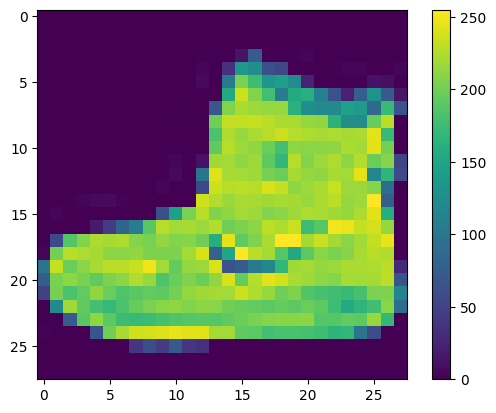

In [94]:
# what the images look like (10 examples)
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

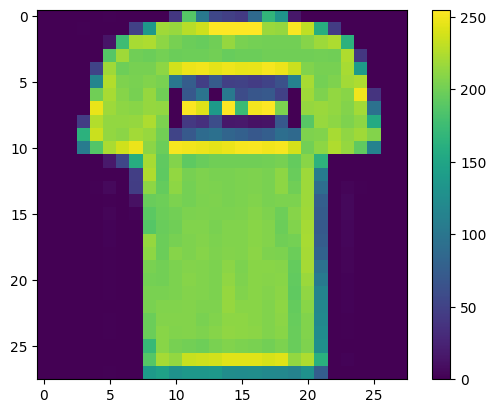

In [95]:
plt.figure()
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

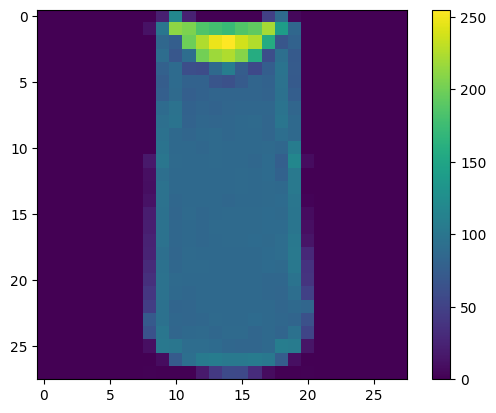

In [96]:
plt.figure()
plt.imshow(train_images[2])
plt.colorbar()
plt.grid(False)
plt.show()

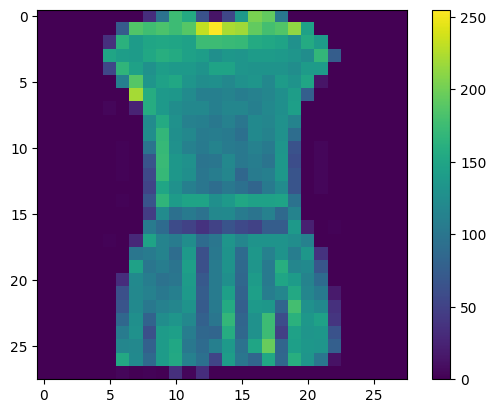

In [97]:
plt.figure()
plt.imshow(train_images[3])
plt.colorbar()
plt.grid(False)
plt.show()

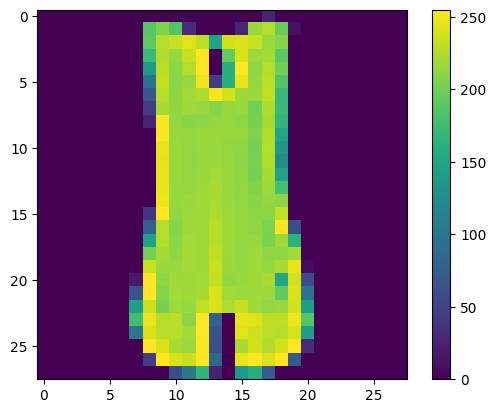

In [98]:
plt.figure()
plt.imshow(train_images[4])
plt.colorbar()
plt.grid(False)
plt.show()

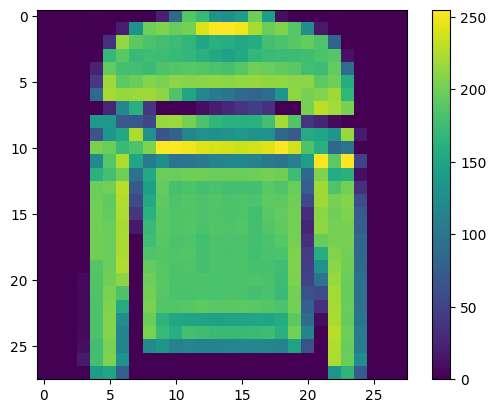

In [99]:
plt.figure()
plt.imshow(train_images[5])
plt.colorbar()
plt.grid(False)
plt.show()

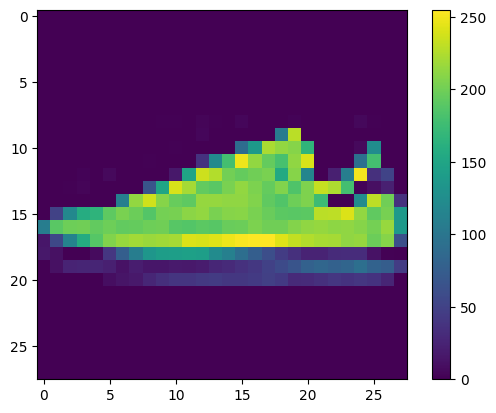

In [100]:
plt.figure()
plt.imshow(train_images[6])
plt.colorbar()
plt.grid(False)
plt.show()

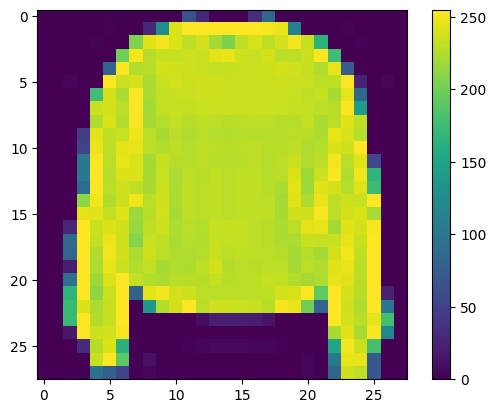

In [101]:
plt.figure()
plt.imshow(train_images[7])
plt.colorbar()
plt.grid(False)
plt.show()

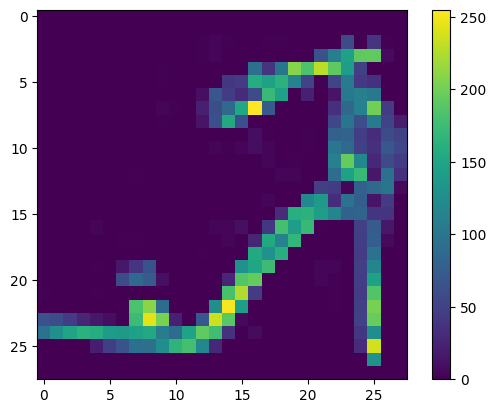

In [102]:
plt.figure()
plt.imshow(train_images[8])
plt.colorbar()
plt.grid(False)
plt.show()

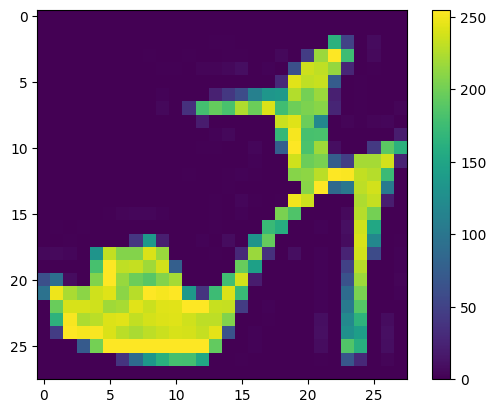

In [103]:
plt.figure()
plt.imshow(train_images[9])
plt.colorbar()
plt.grid(False)
plt.show()

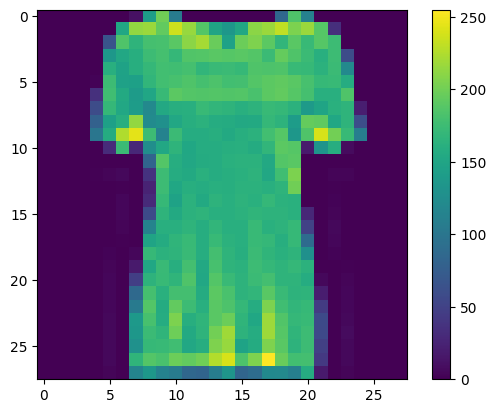

In [104]:
plt.figure()
plt.imshow(train_images[10])
plt.colorbar()
plt.grid(False)
plt.show()

In [105]:
# Data Preprocessing

# squish all the values from 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

In [106]:
# Creating the Model

model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)), # input layer 1 => 784 pixels
    #dense (all the neurons from previous layer are connected to every neuron in this layer)
    keras.layers.Dense(128, activation = 'relu'), # hidden layer 2 => rectified linear unit (relu)
    keras.layers.Dense(10, activation = 'softmax') # output layer 3 => 10 classes to predict for
])

In [107]:
# Compile the Model

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']) # algorithm performs the gradient descent

In [110]:
# Training the Model

model.fit(train_images, train_labels, epochs = 10) # epochs is a hyperparamter

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2378 - accuracy: 0.9118
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2312 - accuracy: 0.9130
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2225 - accuracy: 0.9159
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2153 - accuracy: 0.9188
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2071 - accuracy: 0.9224
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2039 - accuracy: 0.9231
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1967 - accuracy: 0.9265
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1917 - accuracy: 0.9283
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1867 - accuracy: 0.9298
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.182

In [ ]:
# Testing the Model

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose = 1) # verbose (how much is printing out to the console)

print('Test accuracy:', test_acc) # overfitting (memorize the data)

313/313 [==============================] - 0s 705us/step - loss: 0.3708 - accuracy: 0.8711
Test accuracy: 0.8711000084877014


In [ ]:
# Making Predictions

predictions = model.predict(test_images) # all the test images
print(predictions)

313/313 [==============================] - 0s 860us/step
[[3.0215824e-06 1.1138670e-08 7.0078743e-09 ... 1.9269820e-02
  2.3249182e-05 7.0141876e-01]
 [1.8729763e-05 2.9557389e-08 9.9613100e-01 ... 7.5351237e-17
  6.8211214e-08 1.0492902e-15]
 [5.3030573e-11 9.9999994e-01 7.9716229e-14 ... 2.9103492e-27
  1.5023005e-15 6.4357296e-24]
 ...
 [9.5220730e-06 2.0964037e-09 1.5957015e-05 ... 5.4650457e-07
  9.9992877e-01 3.5530169e-11]
 [4.9652137e-08 9.9990422e-01 5.2061275e-09 ... 7.0038946e-18
  2.0328390e-09 1.3918944e-14]
 [1.5776554e-06 1.9064920e-10 1.9763165e-08 ... 1.7366088e-05
  2.3045262e-05 1.0599248e-07]]


In [ ]:
test_images.shape # array of 10.000 entries

(10000, 28, 28)

In [ ]:
print(predictions[0]) # prediction 0

[3.0215824e-06 1.1138670e-08 7.0078743e-09 7.1015793e-09 1.2233063e-06
 2.7928266e-01 1.1978289e-06 1.9269820e-02 2.3249182e-05 7.0141876e-01]


In [ ]:
print(np.argmax(predictions[0])) # prediction for a class

9


Ankle boot


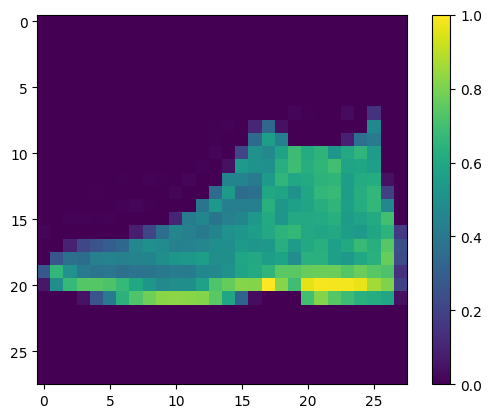

In [ ]:
print(class_names[np.argmax(predictions[0])]) # prediction for a class

# show the image
plt.figure()
plt.imshow(test_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Pullover


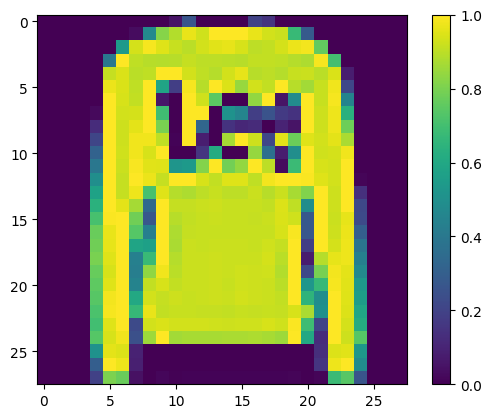

In [ ]:
print(class_names[np.argmax(predictions[1])]) # prediction for a class

# show the image
plt.figure()
plt.imshow(test_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

Trouser


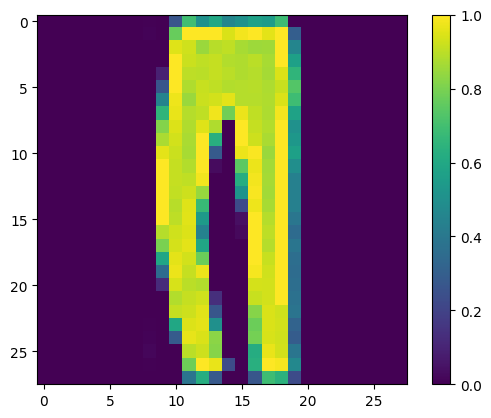

In [ ]:
print(class_names[np.argmax(predictions[2])]) # prediction for a class

# show the image
plt.figure()
plt.imshow(test_images[2])
plt.colorbar()
plt.grid(False)
plt.show()

1/1 [==============================] - 0s 12ms/step


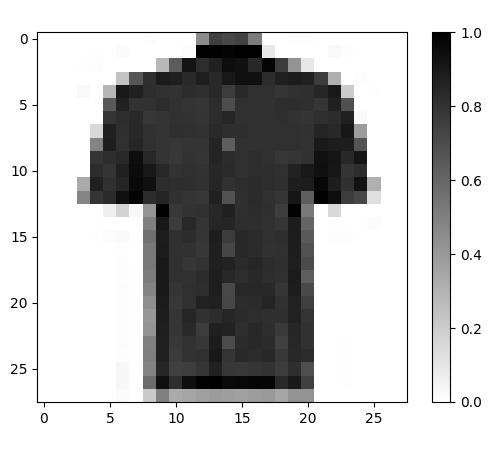

In [111]:
# type a number and show the image, expected and guess the clothes
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
  class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  prediction = model.predict(np.array([image]))
  predicted_class = class_names[np.argmax(prediction)]

  show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
  plt.figure()
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title("Excpected: " + label)
  plt.xlabel("Guess: " + guess)
  plt.colorbar()
  plt.grid(False)
  plt.show()


def get_number():
  while True:
    num = input("Pick a number: ")
    if num.isdigit():
      num = int(num)
      if 0 <= num <= 1000:
        return int(num)
    else:
      print("Try again...")

num = get_number()
image = test_images[num]
label = test_labels[num]
predict(model, image, label)
